In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#import dataste
coca_df = pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
coca_df.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


## EDA

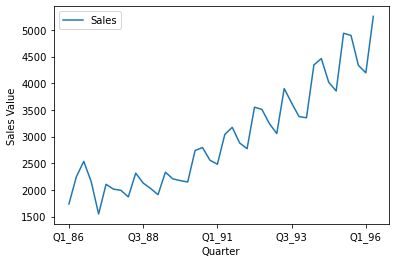

In [3]:
#data visulization, sales values over the years
coca_df.plot("Quarter", "Sales", ylabel="Sales Value");

In [4]:
#Creating quarter and year column in the datset
coca_df["quarter"] = coca_df["Quarter"].str[0:2]
temp = pd.to_datetime(coca_df["Quarter"].str[3:], format="%y")
coca_df["year"] = temp.dt.strftime("%Y")

In [5]:
coca_df.head()

,Quarter,Sales,quarter,year
0,Q1_86,1734.827000,Q1,1986
1,Q2_86,2244.960999,Q2,1986
2,Q3_86,2533.804993,Q3,1986
3,Q4_86,2154.962997,Q4,1986
4,Q1_87,1547.818996,Q1,1987


In [6]:
#Dummy varibales creation
coca_df_eda = pd.concat([coca_df.iloc[:,0:], pd.get_dummies(coca_df.quarter)],axis=1)
coca_df_eda.head()

,Quarter,Sales,quarter,year,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,1986,1,0,0,0
1,Q2_86,2244.960999,Q2,1986,0,1,0,0
2,Q3_86,2533.804993,Q3,1986,0,0,1,0
3,Q4_86,2154.962997,Q4,1986,0,0,0,1
4,Q1_87,1547.818996,Q1,1987,1,0,0,0


### Four Dummy varibales are creates for quarters but only 3 are used in the models

In [7]:
#Adding varibales for time sequence, expontial model, quadratic model
coca_df_eda["t"] = coca_df_eda.index + 1
coca_df_eda["log_Sales"] = coca_df_eda["Sales"].apply(np.log)
coca_df_eda["t_square"] = pow(coca_df_eda["t"],2)
coca_df_eda.head()

,Quarter,Sales,quarter,year,Q1,Q2,Q3,Q4,t,log_Sales,t_square
0,Q1_86,1734.827000,Q1,1986,1,0,0,0,1,7.458663,1
1,Q2_86,2244.960999,Q2,1986,0,1,0,0,2,7.716443,4
2,Q3_86,2533.804993,Q3,1986,0,0,1,0,3,7.837477,9
3,Q4_86,2154.962997,Q4,1986,0,0,0,1,4,7.675529,16
4,Q1_87,1547.818996,Q1,1987,1,0,0,0,5,7.344602,25


In [8]:
coca_df_eda.shape

(42, 11)

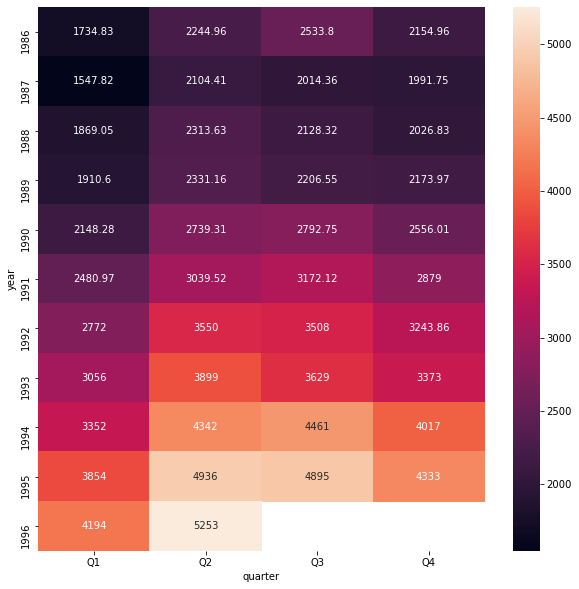

In [9]:
plt.figure(figsize=(10,10))
heatmap_y_q = pd.pivot_table(data= coca_df_eda, values="Sales", index="year",columns="quarter")
sns.heatmap(heatmap_y_q, annot=True, fmt="g");

In [10]:
#Splitting the data
train = coca_df_eda.head(38)
test = coca_df_eda.tail(4)

In [11]:
train.head()

,Quarter,Sales,quarter,year,Q1,Q2,Q3,Q4,t,log_Sales,t_square
0,Q1_86,1734.827000,Q1,1986,1,0,0,0,1,7.458663,1
1,Q2_86,2244.960999,Q2,1986,0,1,0,0,2,7.716443,4
2,Q3_86,2533.804993,Q3,1986,0,0,1,0,3,7.837477,9
3,Q4_86,2154.962997,Q4,1986,0,0,0,1,4,7.675529,16
4,Q1_87,1547.818996,Q1,1987,1,0,0,0,5,7.344602,25


## Models

In [12]:
#Linear model
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
import math

linear_model = smf.ols("Sales ~ t", data=train).fit()
pred_linear = linear_model.predict(test.t)
rmse_linear = math.sqrt(mean_squared_error(test.Sales, pred_linear))
rmse_linear

591.5532957223963

In [13]:
#Exponential model

exp_model = smf.ols("log_Sales ~ t", data=train).fit()
pred_exp = exp_model.predict(test.t)
rmse_exp = math.sqrt(mean_squared_error(test.Sales, np.exp(pred_exp)))
rmse_exp

466.24797310672346

In [14]:
#Quadratic 

quad_model = smf.ols("Sales~t+t_square", data=train).fit()
pred_quad = quad_model.predict(test[["t", "t_square"]])
rmse_quad = math.sqrt(mean_squared_error(test.Sales, pred_quad))
rmse_quad

475.56183518315095

In [15]:
#Additive seasonality

add_sea_model = smf.ols("Sales ~ Q1+Q2+Q3", data=train).fit()
pred_add_sea = add_sea_model.predict(test[["Q1","Q2", "Q3"]])
rmse_add_sea = math.sqrt(mean_squared_error(test.Sales, pred_add_sea))
rmse_add_sea

1860.0238154547276

In [16]:
# Additive Seasonality with Quadratic 

add_quad_model = smf.ols("Sales ~ t+t_square+Q1+Q2+Q3", data=train).fit()
pred_add_quad = add_quad_model.predict(test[["t", "t_square","Q1","Q2", "Q3"]])
rmse_add_quad = math.sqrt(mean_squared_error(test.Sales, pred_add_quad))
rmse_add_quad

301.7380071934617

In [17]:
#Multiplicative Seasonality

mul_sea_model = smf.ols("log_Sales ~ Q1+Q2+Q3", data=train).fit()
pred_mul_sea = mul_sea_model.predict(test[["Q1","Q2", "Q3"]])
rmse_mul_sea = math.sqrt(mean_squared_error(test.Sales, np.exp(pred_exp)))
rmse_mul_sea

466.24797310672346

In [18]:
#linear with additive seasonality

lin_sea_model = smf.ols("Sales ~ t+Q1+Q2+Q3", data=train).fit()
pred_lin_sea = lin_sea_model.predict(test[["t","Q1","Q2", "Q3"]])
rmse_lin_sea = math.sqrt(mean_squared_error(test.Sales, pred_lin_sea))
rmse_lin_sea

464.98290239822165

### ARIMA Model

In [19]:
#Gridsearch to find the best parameter
from statsmodels.tsa.arima_model import ARIMA

X = coca_df_eda[["Sales", "t"]]
X = X.astype('float32')
train_arima = X.head(38)
test_arima = X.tail(4)
    
def evaluate_arima_model(order):
    model = ARIMA(train_arima.Sales, order=order).fit()
    pred = model.forecast(steps=4)[0]
    rmse_value = math.sqrt(mean_squared_error(test_arima.Sales, pred))
    return rmse_value

def evaluate_model(p_values, d_values, q_values):
    rmse_df = pd.DataFrame()
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse  = evaluate_arima_model(order)
                    rmse_df = rmse_df.append({"order":order, "rmse_value":rmse}, ignore_index=True)
                except:
                    continue
    return rmse_df

In [20]:
import warnings
p_values = list(range(0, 5))
d_values = list(range(0, 5))
q_values = list(range(0, 5))
warnings.filterwarnings("ignore")
result = evaluate_model(p_values, d_values, q_values)

In [21]:
#Best parameter for ARIMA model
result.sort_values("rmse_value").head(1)

,order,rmse_value
37,"(3, 1, 1)",80.94764


In [22]:
#ARIMA MODEL
arima_model = ARIMA(train_arima.Sales, order=(3,1,1)).fit()
predict = arima_model.forecast(steps=4)[0]
rmse_arima = math.sqrt(mean_squared_error(test_arima.Sales, predict))
np.round(rmse_arima,2)

80.95

In [23]:
#Compare the results
rmse_data = {"model":pd.Series(["linear_model","exp_model","quad_model","add_sea_model","add_quad_model","mul_sea_model",
                               "lin_sea_model", "arima_model"]), 
             "RMSE Value": pd.Series([rmse_linear, rmse_exp, rmse_quad,rmse_add_sea, rmse_add_quad, rmse_mul_sea,
                                      rmse_lin_sea, rmse_arima])}
table_rmse = pd.DataFrame(rmse_data)
table_rmse.sort_values(["RMSE Value"])

,model,RMSE Value
7,arima_model,80.947640
4,add_quad_model,301.738007
6,lin_sea_model,464.982902
1,exp_model,466.247973
5,mul_sea_model,466.247973
2,quad_model,475.561835
0,linear_model,591.553296
3,add_sea_model,1860.023815


## From the above results ARIMA model is best suited for this data